In [1]:
#!usr/bin/env python
#
#Import packages we need for calculating, plotting, and managing arrays.
import astropy as ap
import numpy as np
import matplotlib as matlib
import matplotlib.pyplot as plt
%matplotlib notebook
import cython
import time

# read data

In [2]:
#Read data from file as a table
from astropy.table import Table

#data_directory = '/home/ypeng22/'
data_directory = '/Users/kellydouglass/Documents/Research/Voids/'

data_filename = data_directory + 'VAST/VoidFinder/vollim_dr7_cbp_102709.dat'

data = Table.read (data_filename, format='ascii.commented_header')

# convert sky coords to cartesian coords

In [3]:
#Convert each galaxy's sky coordinates (ra, dec, comoving distance) into cartesian coordinates (x, y, z).
# import sys
# sys.path.insert(0, "/gpfs/fs1/home/ypeng22/VAST/VoidFinder/")
# from vast.voidfinder import ra_dec_to_xyz

DtoR = np.pi/180.
RtoD = 180./np.pi

def ra_dec_to_xyz(galaxy_table,
                  distance_metric='comoving',
                  h=1.0,
                  ):
    """
    Description
    ===========
    
    Convert galaxy coordinates from ra-dec-redshift space into xyz space.
    
    
    Parameters
    ==========
    
    galaxy_table : astropy.table of shape (N,?)
        must contain columns 'ra' and 'dec' in degrees, and either 'Rgal' in who knows
        what unit if distance_metric is 'comoving' or 'redshift' for everything else
        
    distance_metric : str
        Distance metric to use in calculations.  Options are 'comoving' 
        (default; distance dependent on cosmology) and 'redshift' (distance 
        independent of cosmology).
        
    h : float
        Fractional value of Hubble's constant.  Default value is 1 (where 
        H0 = 100h).
        
        
    Returns
    =======
    
    coords_xyz : numpy.ndarray of shape (N,3)
        values of the galaxies in xyz space
    """
    
    
    if distance_metric == 'comoving':

        r_gal = galaxy_table['Rgal'].data

    else:

        r_gal = c*galaxy_table['redshift'].data/(100*h)


    ra = galaxy_table['ra'].data

    dec = galaxy_table['dec'].data

    ############################################################################
    # Convert from ra-dec-radius space to xyz space
    #---------------------------------------------------------------------------
    ra_radian = ra*DtoR

    dec_radian = dec*DtoR

    x = r_gal*np.cos(ra_radian)*np.cos(dec_radian)

    y = r_gal*np.sin(ra_radian)*np.cos(dec_radian)

    z = r_gal*np.sin(dec_radian)

    num_gal = x.shape[0]

    coords_xyz = np.concatenate((x.reshape(num_gal,1),
                                 y.reshape(num_gal,1),
                                 z.reshape(num_gal,1)), axis=1)
    ############################################################################

    return coords_xyz


coords_xyz = ra_dec_to_xyz(data)

# find nearest neighbor and calculate distance

In [4]:
#This is already coded up in a little function within VoidFinder.
#from vast.voidfinder.avsepcalc import av_sep_calc
# #To gather the nearest distances that we want, we should do
#distances = av_sep_calc(coords_xyz,1)
#where each row in 'coords_xyz corresponds to a galaxy. Then, distances[i] contains the nearst neighbor distance for the ith galaxy 

#Not sure but do we need to do both Tree search and av_sep_calc? or either one of them?

#Now we need to find the mean and standard deviation of these nearest-neighbor distances
# avgdis = np.mean(distances)
# stddis = np.std(distances)
#if things look bad, try np.std(distances, ddof=1)

#alternative method 
#Use sklearn.neighbors.KDTree to find the nearest neighbor. 
# #
# #First, build the search tree for all of the galaxies:
from sklearn import neighbors
# galaxy_tree = neighbors.KDTree(coords_xyz)

# #Second, find the distances to the nearst neighbors. If we query 'galaxy_tree' for the nearst neighbor of an object, it will return the object itself. So, we need the second-nearest neighbor to actually find the nearest neighbor. To query the tree for the 2nd nearest neighbor, we do
# distances, indices = galaxy_tree.query(coords_xyz, k=2)

# #This will return an array of distances, 'distances', which contains the distance for each object in 'coords_xyz' to the first nearest neighbor (itself) and the second nearest neighbor. Since we only want the distances to the second nearest neighbors, we can do 
# all_2nd_distances = distances[:,1]

def av_sep_calc(coords_xyz, n):
    """
    Description
    ===========
    
    Find the average distance to 3rd nearest neighbor and some related properties.
    
    Note: Sklearn KDTree implementation outperformed scipy KDTree by a ridiculous
          factor on sim dataset of 37 million galaxies
    
    Parameters
    ==========
    
    coords_xyz : numpy.ndarray of shape (N, 3)
        Cartesian coordinates of the relevant galaxies in xyz space
        
    n : int
        nth nearest neighbor to return distances for (i.e. for 3rd nearest
        neighbor separation n=3)
        
    
    Returns
    =======
    
    all_nth_distances : numpy.ndarray of shape (N,)
        all distances to the nth nearest neighbor

    """
    
    #avsep_start = time.time()

    #gal_array = to_array(GALTABLEXYZ)
    
    galaxy_tree = neighbors.KDTree(coords_xyz)

    ############################################################################
    # Because the galaxies are themselves contained in gal_array, that means
    # the output 'distances[:,0]' will be the input galaxy indices, since
    # their distances from themselves is 0.  So the query output columns look 
    # like:
    #
    # 0     1          2          3         ...
    # self  1st neigh  2nd neigh  3rd neigh ...
    #
    # So for example if we want the 3rd nearest neighbor distances, we use as 
    # input to the KDtree 'k=n+1', and our result will be at column index 'n'
    #---------------------------------------------------------------------------
    distances, indices = galaxy_tree.query(coords_xyz, k=n+1)
    
    all_nth_distances = distances[:,n]

    #avg = np.mean(all_3rd_distances)

    #sd = np.std(all_3rd_distances)

    #dist_lim = avg + 1.5*(sd)
    ############################################################################
    

    #return dist_lim, avg, sd, all_3rd_distances
    
    return all_nth_distances

distances = av_sep_calc(coords_xyz,1)

# plot histogram of nearest distance

<IPython.core.display.Javascript object>


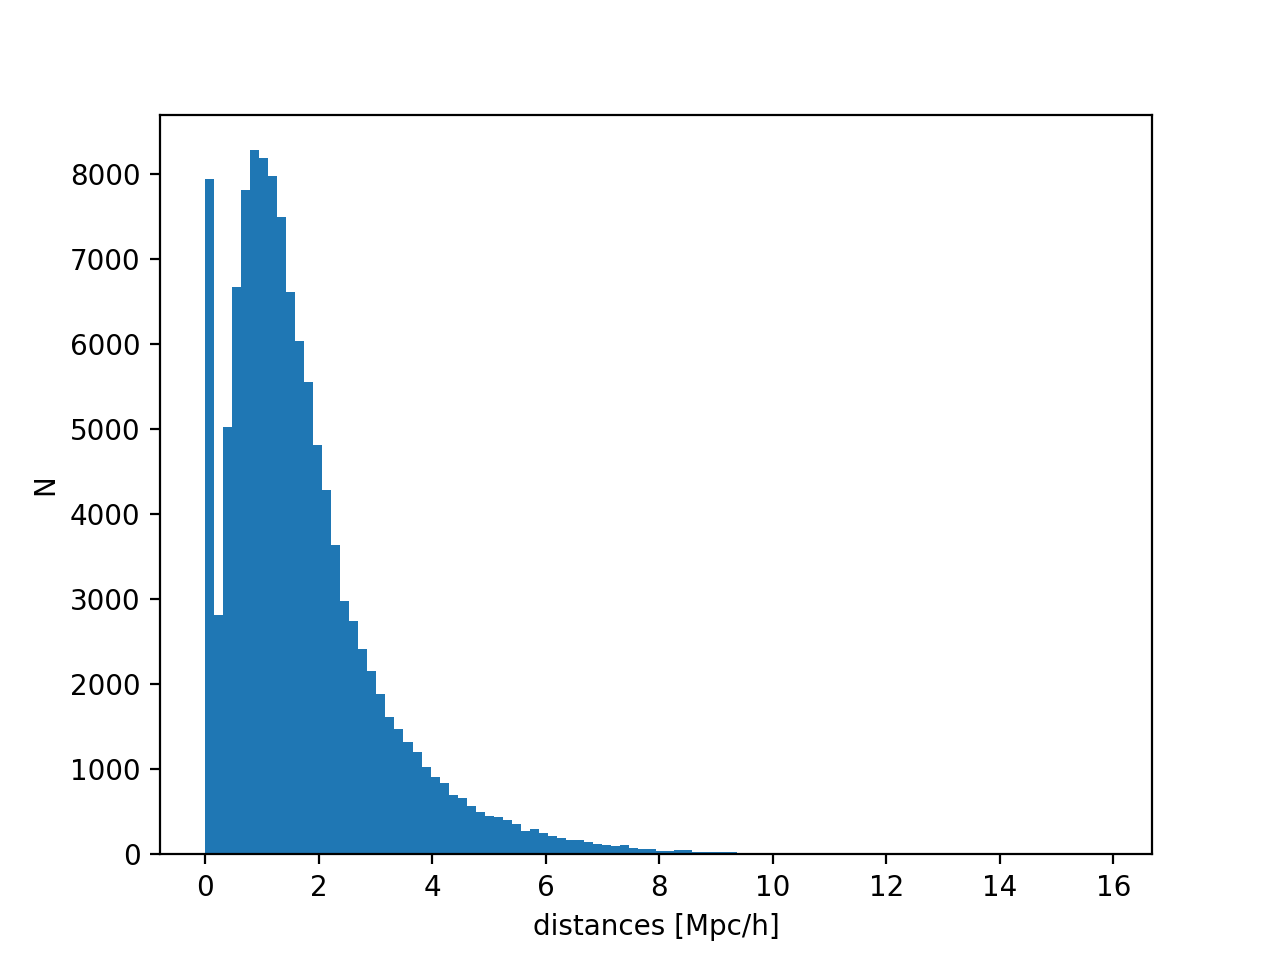

In [6]:
#Now we plot the histogram of these nearest neighbor distances.
plt.figure()

plt.hist(distances, bins=100)

plt.xlabel('distances [Mpc/h]')
plt.ylabel('N');
#plt.savefig('./histodis.png')#save picture

# plot nearest-neighbor distances versus the redshift for each galaxy

<IPython.core.display.Javascript object>


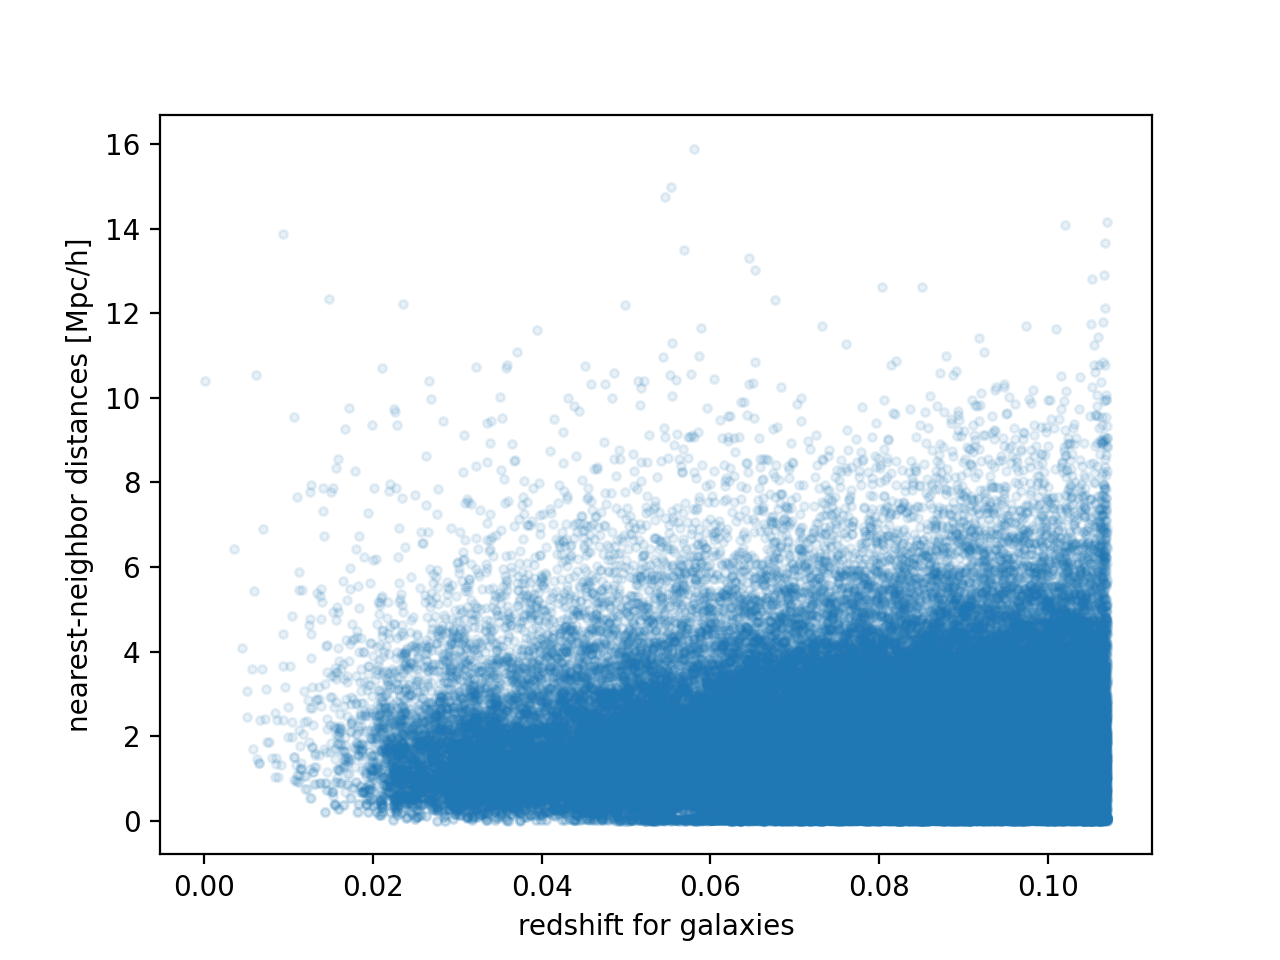

In [8]:
#Plot the nearest-neighbor distances versus the redshift for each galaxy
plt.figure()

#x=distances
#y=[x[2] for x in data]
#plt.plot(x, y)#plot points
plt.plot(data['redshift'], distances, '.', alpha=0.1)

plt.ylabel('nearest-neighbor distances [Mpc/h]')#name x-axis
plt.xlabel('redshift for galaxies');#name y-axis
#plt.savefig('./disvdrs.png')#save picture

In [9]:
np.sum(distances == 0)

0

# Average density

In [12]:
avg_volume = np.mean(distances**3)
med_volume = np.median(distances**3)

avg_density = 1/avg_volume
med_density = 1/med_volume

print('The average volume for a galaxy is', avg_volume, '(Mpc/h)^3')
print('The average galaxy density is', avg_density, '(Mpc/h)^-3')

print('The median volume for a galaxy is', med_volume, '(Mpc/h)^3')
print('The median galaxy density is', med_density, '(Mpc/h)^-3')

The average volume for a galaxy is 20.41673697494523 (Mpc/h)^3
The average galaxy density is 0.04897942316772598 (Mpc/h)^-3
The median volume for a galaxy is 2.679559309414568 (Mpc/h)^3
The median galaxy density is 0.3731956954587733 (Mpc/h)^-3
